In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer='adam')
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try5.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try5.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=300, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/300
49/49 [==============================] - 1s 22ms/step - loss: 158.1466 - val_loss: 98.3045

Epoch 00001: loss improved from inf to 138.09100, saving model to data/out\try5.h5
Epoch 2/300
49/49 [==============================] - 0s 2ms/step - loss: 78.7245 - val_loss: 32.3921

Epoch 00002: loss improved from 138.09100 to 60.82034, saving model to data/out\try5.h5
Epoch 3/300
49/49 [==============================] - 0s 2ms/step - loss: 30.2327 - val_loss: 22.2327

Epoch 00003: loss improved from 60.82034 to 28.02026, saving model to data/out\try5.h5
Epoch 4/300
49/49 [==============================] - 0s 2ms/step - loss: 20.2879 - val_loss: 18.2850

Epoch 00004: loss improved from 28.02026 to 19.26077, saving model to data/out\try5.h5
Epoch 5/300
49/49 [==============================] - 0s 1ms/step - loss: 17.4054 - val_loss: 17.9845

Epoch 00005: loss improved from 19.26077 to 18.07455, saving model to data/out\try5.h5
Epoch 6/300
49/49 [==============================] - 0s 

49/49 [==============================] - 0s 2ms/step - loss: 11.9439 - val_loss: 13.2147

Epoch 00046: loss did not improve from 12.16997
Epoch 47/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8161 - val_loss: 13.2294

Epoch 00047: loss improved from 12.16997 to 12.16473, saving model to data/out\try5.h5
Epoch 48/300
49/49 [==============================] - 0s 1ms/step - loss: 12.3445 - val_loss: 13.2671

Epoch 00048: loss did not improve from 12.16473
Epoch 49/300
49/49 [==============================] - 0s 1ms/step - loss: 12.5391 - val_loss: 13.5896

Epoch 00049: loss did not improve from 12.16473
Epoch 50/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8533 - val_loss: 13.3401

Epoch 00050: loss did not improve from 12.16473
Epoch 51/300
49/49 [==============================] - 0s 1ms/step - loss: 12.2943 - val_loss: 13.3335

Epoch 00051: loss did not improve from 12.16473
Epoch 52/300
49/49 [==============================] - 0s 1ms/step - 

49/49 [==============================] - 0s 1ms/step - loss: 11.8612 - val_loss: 13.5366

Epoch 00098: loss did not improve from 12.05760
Epoch 99/300
49/49 [==============================] - 0s 1ms/step - loss: 12.0765 - val_loss: 13.2500

Epoch 00099: loss did not improve from 12.05760
Epoch 100/300
49/49 [==============================] - 0s 1ms/step - loss: 12.2935 - val_loss: 13.2207

Epoch 00100: loss did not improve from 12.05760
Epoch 101/300
49/49 [==============================] - 0s 2ms/step - loss: 12.5037 - val_loss: 13.4396

Epoch 00101: loss did not improve from 12.05760
Epoch 102/300
49/49 [==============================] - 0s 2ms/step - loss: 12.2401 - val_loss: 13.2092

Epoch 00102: loss did not improve from 12.05760
Epoch 103/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9487 - val_loss: 13.1504

Epoch 00103: loss did not improve from 12.05760
Epoch 104/300
49/49 [==============================] - 0s 1ms/step - loss: 11.7427 - val_loss: 13.2042


49/49 [==============================] - 0s 2ms/step - loss: 11.6244 - val_loss: 13.1740

Epoch 00150: loss did not improve from 11.92791
Epoch 151/300
49/49 [==============================] - 0s 2ms/step - loss: 12.2518 - val_loss: 13.0655

Epoch 00151: loss did not improve from 11.92791
Epoch 152/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8623 - val_loss: 13.0393

Epoch 00152: loss did not improve from 11.92791
Epoch 153/300
49/49 [==============================] - 0s 1ms/step - loss: 12.5275 - val_loss: 13.0785

Epoch 00153: loss did not improve from 11.92791
Epoch 154/300
49/49 [==============================] - 0s 1ms/step - loss: 11.7359 - val_loss: 13.0861

Epoch 00154: loss did not improve from 11.92791
Epoch 155/300
49/49 [==============================] - 0s 1ms/step - loss: 12.0260 - val_loss: 13.0696

Epoch 00155: loss did not improve from 11.92791
Epoch 156/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9843 - val_loss: 13.1402

49/49 [==============================] - 0s 2ms/step - loss: 11.9142 - val_loss: 13.0395

Epoch 00203: loss did not improve from 11.84585
Epoch 204/300
49/49 [==============================] - 0s 1ms/step - loss: 11.4092 - val_loss: 13.0197

Epoch 00204: loss did not improve from 11.84585
Epoch 205/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9896 - val_loss: 13.0191

Epoch 00205: loss did not improve from 11.84585
Epoch 206/300
49/49 [==============================] - 0s 1ms/step - loss: 12.3063 - val_loss: 13.0260

Epoch 00206: loss did not improve from 11.84585
Epoch 207/300
49/49 [==============================] - 0s 1ms/step - loss: 11.6406 - val_loss: 13.2707

Epoch 00207: loss did not improve from 11.84585
Epoch 208/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9363 - val_loss: 13.2920

Epoch 00208: loss did not improve from 11.84585
Epoch 209/300
49/49 [==============================] - 0s 1ms/step - loss: 12.1607 - val_loss: 13.0583

49/49 [==============================] - 0s 1ms/step - loss: 12.3938 - val_loss: 12.8894

Epoch 00255: loss did not improve from 11.75949
Epoch 256/300
49/49 [==============================] - 0s 1ms/step - loss: 12.2256 - val_loss: 12.8868

Epoch 00256: loss did not improve from 11.75949
Epoch 257/300
49/49 [==============================] - 0s 1ms/step - loss: 11.7735 - val_loss: 12.9357

Epoch 00257: loss did not improve from 11.75949
Epoch 258/300
49/49 [==============================] - 0s 2ms/step - loss: 12.0498 - val_loss: 13.0862

Epoch 00258: loss did not improve from 11.75949
Epoch 259/300
49/49 [==============================] - 0s 2ms/step - loss: 11.7738 - val_loss: 12.9214

Epoch 00259: loss did not improve from 11.75949
Epoch 260/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8902 - val_loss: 13.0037

Epoch 00260: loss did not improve from 11.75949
Epoch 261/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8616 - val_loss: 12.9408

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try5.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 77139.47     5926.347 ]
 [127292.24    12221.441 ]
 [ 21137.127    2359.775 ]
 ...
 [ 24942.06     2628.9158]
 [ 93226.414    8265.024 ]
 [167341.53    10002.113 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 500us/step - loss: 11.9807


11.98071575164795

In [18]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [19]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   77139.468750   5926.347168
1    124093149  127292.242188  12221.441406
2    124090750   21137.126953   2359.774902
3    124092491   12435.034180   1618.596069
4    124091871    9532.735352   1056.273560
..         ...            ...           ...
847  124088805   15291.041016   1973.474365
848  124089757   12117.037109   1456.372803
849  124089569   24942.060547   2628.915771
850  124092518   93226.414062   8265.024414
851  124090644  167341.531250  10002.113281

[852 rows x 3 columns]


In [20]:
df.to_csv('data/out/try5_out.csv',index=False)

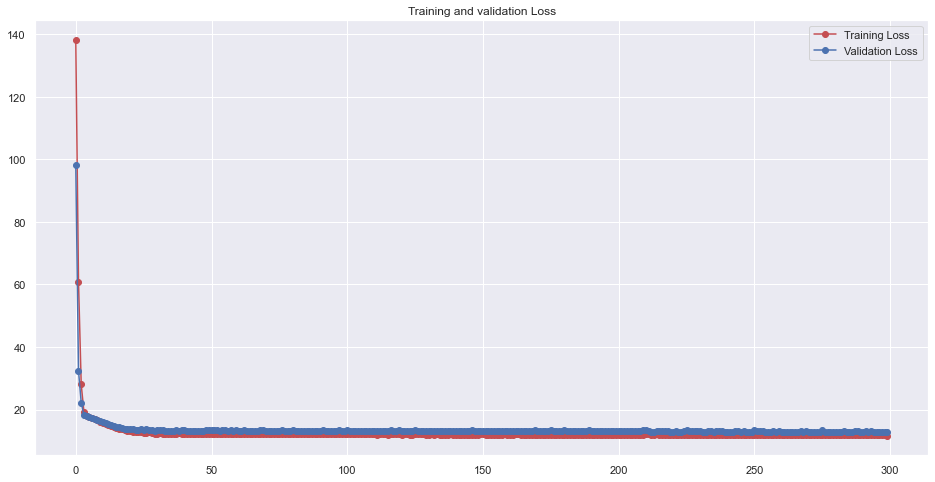

<Figure size 432x288 with 0 Axes>

In [21]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()